# Mandatory Assignment 2: Sampling Customers

**This is the second of three mandatory assignments to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The assignment is to be done individually. You are under no circumstances allowed to collaborate with anyone on solving the exercises (cf. the full policy on this on the course website)**
- **You must hand in one Jupyter notebook (this notebook) with your solution**
- **The hand-in of the notebook is due 2019-11-10, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **You may use more cells than the provided ones for your answers**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**

---
## Introduction
When computing group aggregates from a sample, simple random sampling does not give good results. Instead, a representative sample can be obtained by storing each record seen from a sample of the elements we group by. 

In this assignment you should implement this sampling method on a stream of customer spendings.

### Example
Suppose you are sampling from a stream of customer spendings. Each element of the stream consists of a customer ID and an amount. For example:

`123e4567-e89b-12d3-a456-426655440000 29.99`

To obtain a representative sample, you should sample some customer IDs and make sure that every occurrence of the sampled customer IDs are in your final sample. For example, if the customer ID `123e4567-e89b-12d3-a456-426655440000` is among the sampled customer IDs, every element with this ID should be in your sample. 

## Reading the stream
The following code reads a remote file line by line. It is wrapped in a generator to make it easier to extend. You should design your algorithm to read from the generator as a stream. You may extend or modify this to fit your requirements.

In [25]:
import ssl
import numpy as np
import urllib
import mmh3
import pandas as pd
import seaborn as sns

def stream(n):
    i = 0
    with urllib.request.urlopen('https://files.dtu.dk/fss/public/link/public/stream/read/spending?linkToken=wkMPLdtDDyvQQw8o&itemName=spending') as f:
        for line in f:
            element = line.rstrip().decode("utf-8")
            yield element
            i += 1
            if i == n:
                break

In [26]:
STREAM_SIZE = 10
customer_stream = stream(STREAM_SIZE)

## Exercise 1
Implement an algorithm that computes a sample from the stream. The sample must be representative of customers, i.e., you should be able to answer group aggregate questions from it.

The sample size should be approximately 10% of the number of elements read from the stream.

It is important that your algorithm is a streaming algorithm. This means that your algorithm should update the sample every time an element from the stream is processed, and you should also only process the stream once.

### Hints
Hint 1: Since simple random sampling is not a good idea, you should not use the reservoir sampling algorithm.

Hint 2: The sample does not have to be exactly $k$ elements.

Hint 3: You should use a hash function and the fact that it can be used to uniformly map elements from a large universe to a smaller domain. Murmurhash3 (`mmh3`) is a suitable hash function from strings to integers for this.

**Sampling the stream**
In order to sample from the stream, the stream was read from generator provided through a for loop. The input stream is tab delimited, with two columns, corresponding to a string with a customer ID, and a float with the corresponding customer spend. 
The aim is to compute a sample of the stream that is representative of each customer, without having sample the entire stream, more specifically only sampling 10% of the customers in the stream.
This is carried out by an algorithm that hashes each customerID from 0-9, with each customer having the uniformally distributed probability of 1/10 to be hashed with the value 0. If the hash value is equal to zero, the customer and its corresponding spending value is added to a list. The hashing function mmh3 is therefore utilized as a random number generator, but ensuring that the same customerID will always obtain the same hash value.
The list is subsequently put into a dataframe, which should consist of ~10% of the customers in the stream.

In [27]:
def sample_stream(streams):
    sample = []
    for stream in streams:
        customer, spend = stream.split()
        # Hash the customers with values from 0-9. If the value of the hash is 0, keep (1/10 values)
        if (mmh3.hash(customer) % 10 == 0):
            sample.append([customer, float(spend)])

    return pd.DataFrame(sample, columns=['Customer', 'Spend'])

## Exercise 2
Use the sample obtained in the previous exercise to answer the following question.

- What is the average spending per customer?

The average spending per customer is calculated by using pandas groupby function and then taking the mean for each distinct customer. The output is a list of distinct customer and their average spending value.

In [28]:
sample = sample_stream(stream(100000))
avg = sample.groupby('Customer').mean()
avg

,Spend
Customer,
00a877ab-193b-462e-82a9-09f363beb5c5,103.222119
075ab631-dcf9-4789-80b4-8f69d8cd60b8,100.328815
0cde751e-9725-4808-b715-11c1287d5ec6,103.088058
0d0c6bb8-9c3b-4f90-b17e-f762d7582d9a,96.496643
13ca5b0d-da36-47ac-b4b6-752ddff63446,101.808855
...,...
f432a3bc-55b9-478c-9e22-39887b95f937,100.722500
f4c02cb9-a2c7-4528-8020-813159f2c574,107.977426
f81727e5-d8fe-471b-a6a7-71330dc01b1b,93.633893


The customer spend maps as follows:

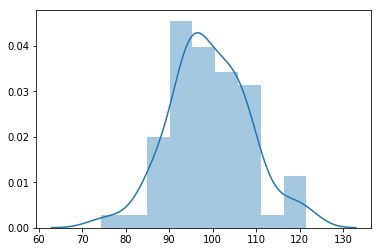

In [8]:
sns.distplot(avg)

Depending on the size of the stream, the distribution, but as the size increases, the more even the distribution seems to be. 

## Exercise 3
Explain why simple random sampling would not give as good an answer to the question in exercise 2 as your new algorithm does.

Hint: Look at the distribution of amounts for some customer in your sample.

Firstly I rendered a few random customer IDs, to display a sample distribution of the sampled customer's amount shown below. Having ran this over 30 times, it was apparent that the distribution was mostly heavily left-skewed, with many purchases of low value, and few of high value. For a random sampling with just sampling random entries, instead of  entries per random customer, the purchasing patterns would have to be normally distributed. This is because the lower values  have a higher probability of being chosen vs the higher values, giving a non-representative average of per customer spend. 

,Customer,Spend
3,f3f880bb-f71c-490d-bd01-cce8d6470013,33.79
18,f3f880bb-f71c-490d-bd01-cce8d6470013,9.80
102,f3f880bb-f71c-490d-bd01-cce8d6470013,149.97
170,f3f880bb-f71c-490d-bd01-cce8d6470013,158.50
417,f3f880bb-f71c-490d-bd01-cce8d6470013,152.21
...,...,...
9127,f3f880bb-f71c-490d-bd01-cce8d6470013,0.59
9145,f3f880bb-f71c-490d-bd01-cce8d6470013,46.95
9267,f3f880bb-f71c-490d-bd01-cce8d6470013,91.89
9277,f3f880bb-f71c-490d-bd01-cce8d6470013,171.79


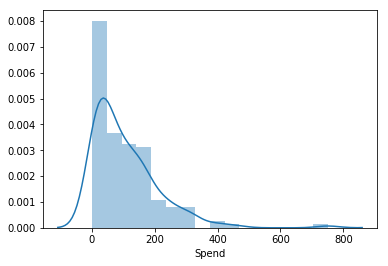

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
# Your code and explanation here
rand_cust=  sample.Customer.sample().values[0]
rand_dist = sample[sample.Customer == rand_cust]
rand_dist

In [ ]:
sns.distplot(rand_dist.Spend)

Another way to view customer spend distribution is through a line plot, which shows inconsistent behavior.

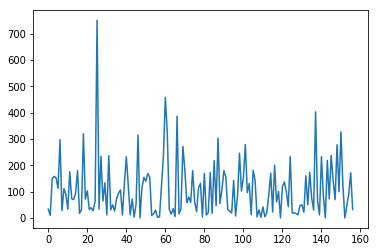

In [29]:
plt.plot(np.arange(len(rand_dist)), rand_dist.Spend)